In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
import os, sys
from sklearn.preprocessing import MinMaxScaler

In [2]:
# ====== 1. Tạo thư mục lưu ảnh ======
img_folder = "./MAGIC/img/"
os.makedirs(img_folder, exist_ok=True)

In [3]:
# ====== 2. Đọc dữ liệu MAGIC ======
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data"
cols = ["fLength","fWidth","fSize","fConc","fConc1",
        "fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"]
df = pd.read_csv(url, names=cols)
df["class"] = df["class"].map({"g":1, "h":0})

print(f"Dữ liệu ban đầu: {df.shape[0]} dòng, {df.shape[1]} cột")

Dữ liệu ban đầu: 19020 dòng, 11 cột


In [4]:
# ====== 3. Phân tích độ lệch & phương sai ======
desc = df.describe().T
desc["variation_ratio"] = desc["std"] / (desc["mean"].abs() + 1e-6)
desc["skewness"] = df.drop("class", axis=1).skew()

high_var_cols = desc[(desc["variation_ratio"] > 3) | (desc["skewness"].abs() > 3)].index.tolist()
print("\nCác cột bị loại do độ lệch cao:", high_var_cols)

df_filtered = df.drop(columns=high_var_cols)
num_cols = df_filtered.columns[:-1]
print(f"Sau lọc: {len(num_cols)} thuộc tính còn lại: {list(num_cols)}\n")


Các cột bị loại do độ lệch cao: ['fWidth', 'fAsym', 'fM3Long', 'fM3Trans']
Sau lọc: 6 thuộc tính còn lại: ['fLength', 'fSize', 'fConc', 'fConc1', 'fAlpha', 'fDist']



C:\Users\prysm\AppData\Local\Temp\ipykernel_5564\1713155671.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=desc.index, y=desc["skewness"], palette="coolwarm")


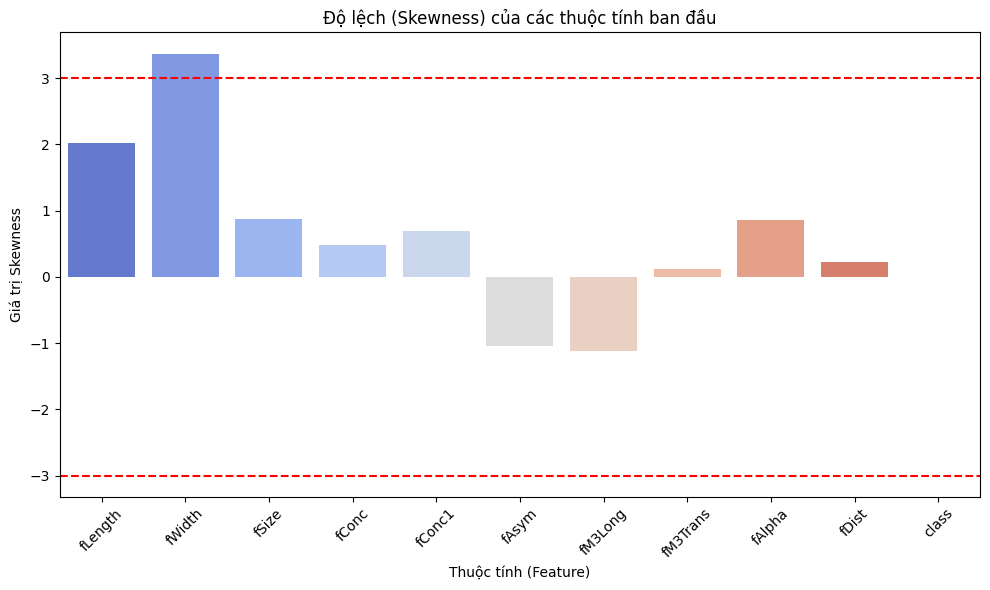

In [5]:
# ====== 4. Vẽ biểu đồ độ lệch (skewness) ======
plt.figure(figsize=(10,6))
sns.barplot(x=desc.index, y=desc["skewness"], palette="coolwarm")
plt.axhline(3, color='r', linestyle='--', label='Ngưỡng lệch cao (3)')
plt.axhline(-3, color='r', linestyle='--')
plt.title("Độ lệch (Skewness) của các thuộc tính ban đầu")
plt.xlabel("Thuộc tính (Feature)")
plt.ylabel("Giá trị Skewness")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(img_folder, "Magic_Do_lech_cac_thuoc_tinh.png"))
plt.show()

Phân phối lớp trước cân bằng:
 class
1    12332
0     6688
Name: count, dtype: int64


C:\Users\prysm\AppData\Local\Temp\ipykernel_5564\2958288594.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts_before.index, y=label_counts_before.values, palette="viridis")


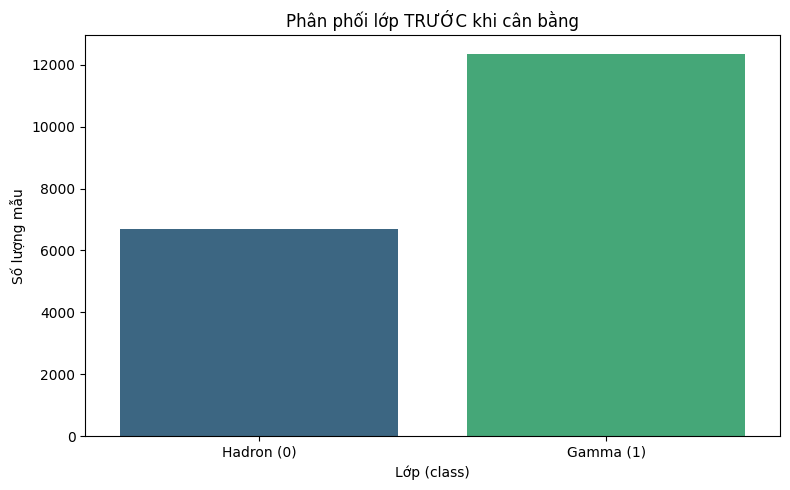

In [6]:
# ====== 5. Phân phối lớp trước xử lý ======
label_counts_before = df_filtered["class"].value_counts()
print("Phân phối lớp trước cân bằng:\n", label_counts_before)

plt.figure(figsize=(8,5))
sns.barplot(x=label_counts_before.index, y=label_counts_before.values, palette="viridis")
plt.title("Phân phối lớp TRƯỚC khi cân bằng")
plt.xlabel("Lớp (class)")
plt.ylabel("Số lượng mẫu")
plt.xticks([0,1], ["Hadron (0)","Gamma (1)"])
plt.tight_layout()
plt.savefig(os.path.join(img_folder, "Magic_PhanPhoi_Lop_TruocCanBang.png"))
plt.show()

In [7]:
# ====== 6. Cân bằng dữ liệu ======
X = df_filtered[num_cols]
y = df_filtered["class"]

smote = SMOTE(random_state=42)  # sử dụng nếu muốn cân bằng
X_res, y_res = smote.fit_resample(X, y)

ros = RandomOverSampler(random_state=42)
X_final, y_final = ros.fit_resample(X_res, y_res)

df_balanced = pd.DataFrame(X_final, columns=num_cols)
df_balanced["class"] = y_final


Phân phối lớp SAU cân bằng:
 class
1    12332
0    12332
Name: count, dtype: int64


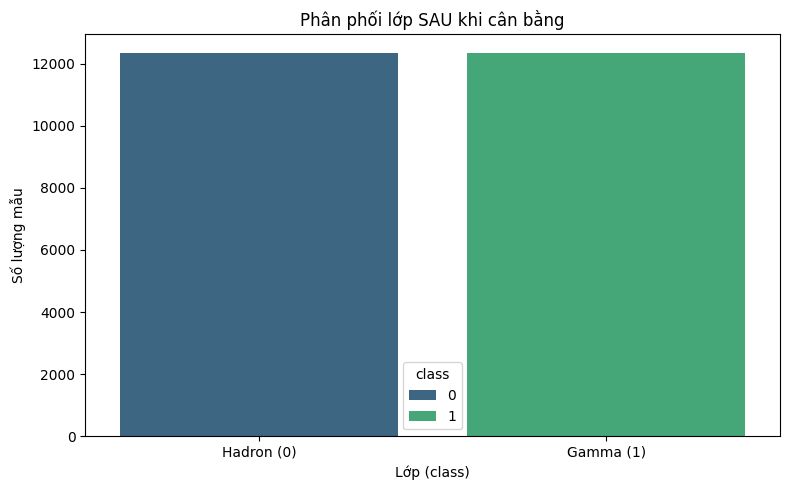

In [8]:
# ====== 7. Phân phối lớp sau cân bằng ======
label_counts_after = df_balanced["class"].value_counts()
print("\nPhân phối lớp SAU cân bằng:\n", label_counts_after)

plt.figure(figsize=(8,5))
sns.barplot(x=label_counts_after.index, y=label_counts_after.values,hue=label_counts_after.index, palette="viridis")
plt.title("Phân phối lớp SAU khi cân bằng")
plt.xlabel("Lớp (class)")
plt.ylabel("Số lượng mẫu")
plt.xticks([0,1], ["Hadron (0)","Gamma (1)"])
plt.tight_layout()
plt.savefig(os.path.join(img_folder, "Magic_PhanPhoi_Lop_SauCanBang.png"))
plt.show()

In [9]:
# ====== 8. So sánh Mean & Std ======
mean_before = df_filtered[num_cols].mean()
mean_after  = df_balanced[num_cols].mean()
std_before  = df_filtered[num_cols].std()
std_after   = df_balanced[num_cols].std()

x = np.arange(len(num_cols))
width = 0.35

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_filtered[num_cols])
df_scaled = pd.DataFrame(scaled, columns=num_cols)

In [10]:
# Chuẩn hóa Std để so sánh công bằng giữa các cột
std_before_norm = std_before / std_before.max()
std_after_norm = std_after / std_after.max()

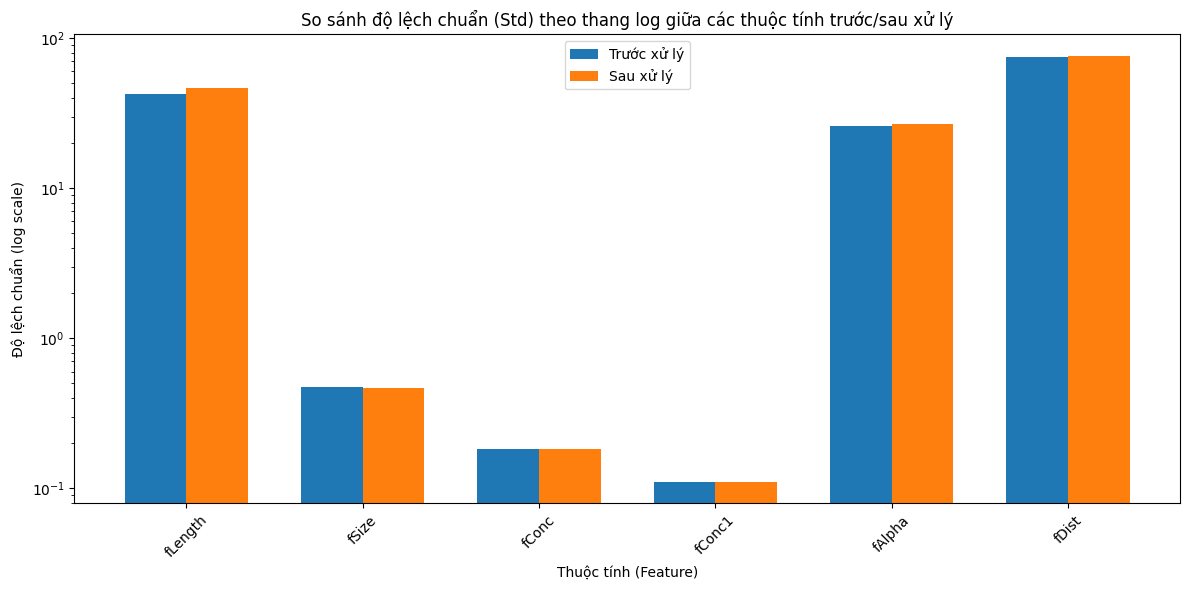

In [11]:
# --- Std (log scale) ---
plt.figure(figsize=(12,6))
plt.bar(x - width/2, std_before.values, width, label="Trước xử lý")
plt.bar(x + width/2, std_after.values, width, label="Sau xử lý")
plt.xticks(x, num_cols, rotation=45)
plt.yscale("log")
plt.title("So sánh độ lệch chuẩn (Std) theo thang log giữa các thuộc tính trước/sau xử lý")
plt.xlabel("Thuộc tính (Feature)")
plt.ylabel("Độ lệch chuẩn (log scale)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(img_folder, "Magic_SoSanh_Std_LogScale.png"))
plt.show()

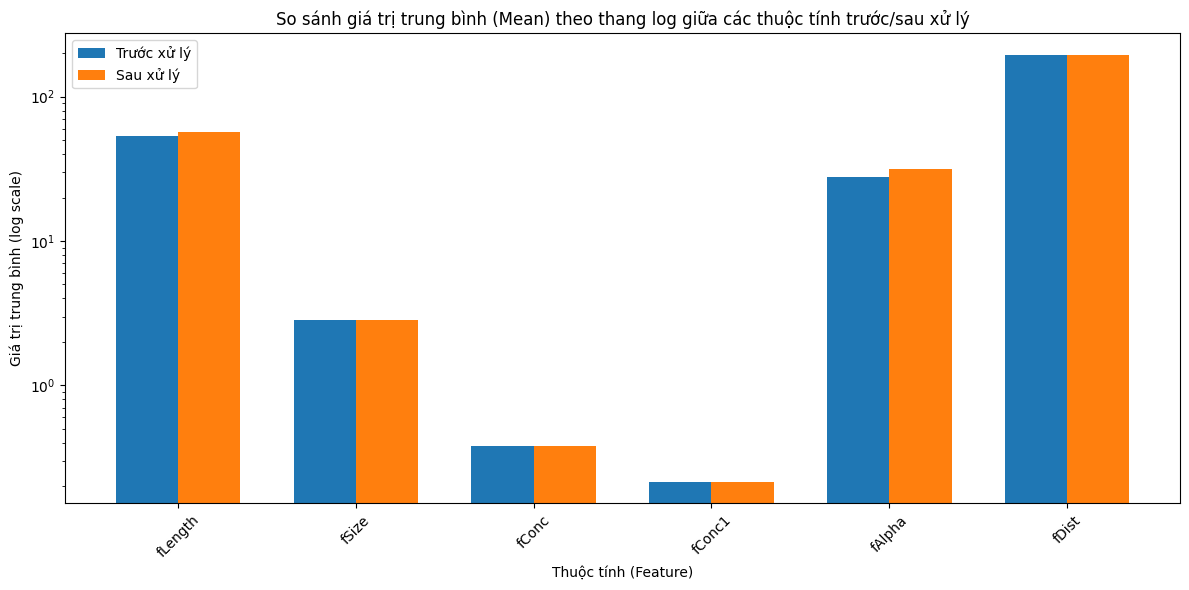

In [12]:
# --- Mean (log scale) ---
plt.figure(figsize=(12,6))
plt.bar(x - width/2, mean_before.values, width, label="Trước xử lý")
plt.bar(x + width/2, mean_after.values,  width, label="Sau xử lý")
plt.xticks(x, num_cols, rotation=45)
plt.yscale("log")
plt.title("So sánh giá trị trung bình (Mean) theo thang log giữa các thuộc tính trước/sau xử lý")
plt.xlabel("Thuộc tính (Feature)")
plt.ylabel("Giá trị trung bình (log scale)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(img_folder, "Magic_SoSanh_Mean_LogScale.png"))
plt.show()

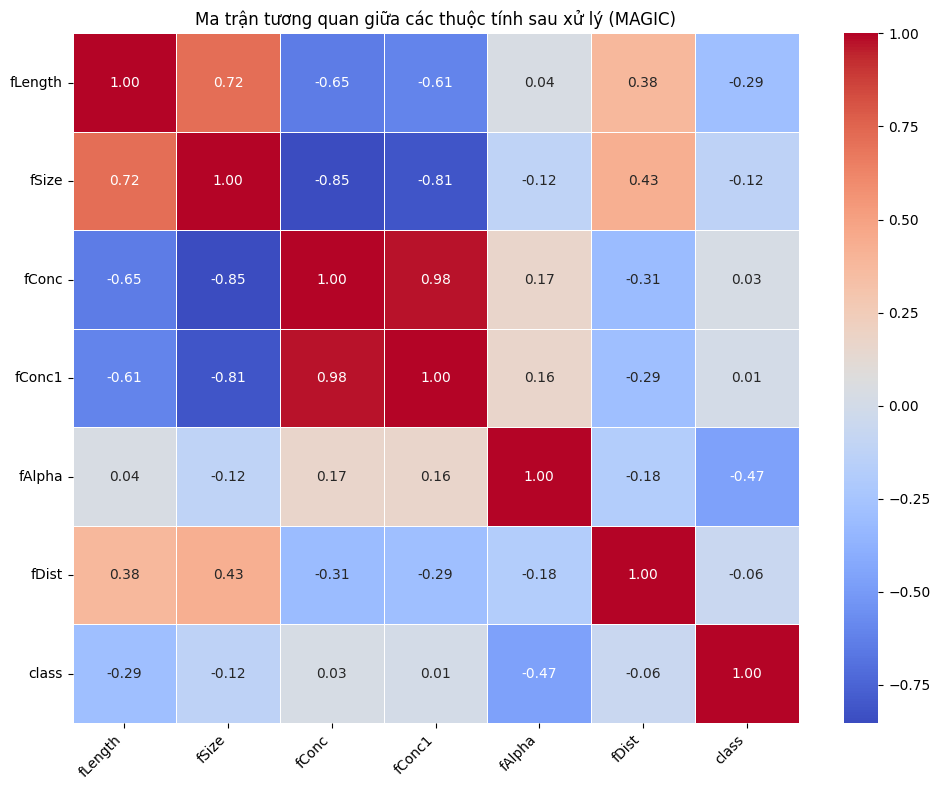

In [13]:
# ====== 9. Ma trận tương quan sau xử lý ======
plt.figure(figsize=(10,8))
corr = df_balanced.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Ma trận tương quan giữa các thuộc tính sau xử lý (MAGIC)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(img_folder, "Magic_MaTran_TuongQuan_SauXuLy.png"))
plt.show()

In [14]:
# ====== 🔟. Xuất dữ liệu sau xử lý ======
output_path = "./MAGIC/magic_filtered_balanced.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_balanced.to_csv(output_path, index=False)